# Project Proposal - PGA Stats
### Isaac Meadow, Jackson Skahill, Alex Eichmann

In [69]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

In [70]:
# Open PGA Tour
browser = webdriver.Chrome()
browser.get("https://www.pgatour.com/stats/stat.101.html")
time.sleep(5)

# Scraping
rows = browser.find_elements(By.TAG_NAME, "tr")
data = []

for row in rows[1:100]:
    cells = row.find_elements(By.TAG_NAME, "td")
    if len(cells) >= 6:
        try:
            player = cells[2].text
            avg_distance = cells[3].text
            rounds = cells[5].text
            data.append([player, rounds, avg_distance])
        except:
            continue

browser.quit()

In [71]:
# Create Data Frame
tour_stats = pd.DataFrame(data, columns=["Player", "Rounds", "Avg Distance"])
tour_stats["Player"] = tour_stats["Player"].str.strip()
tour_stats["Rounds"] = pd.to_numeric(tour_stats["Rounds"], errors="coerce")
tour_stats["Avg Distance"] = pd.to_numeric(tour_stats["Avg Distance"], errors="coerce")
display(tour_stats.head())

,Player,Rounds,Avg Distance
0,Aldrich Potgieter,54.0,324.1
1,Niklas Norgaard,40.0,318.5
2,Rory McIlroy,48.0,317.5
3,Michael Thorbjornsen,58.0,316.2
4,Alejandro Tosti,67.0,315.9


In [72]:
# Other CSV File
tour_data = pd.read_csv("pgaTourData.csv")
tour_data = tour_data[["Player Name", "Rounds", "Fairway Percentage", "Year",
                       "Avg Distance", "gir", "Average Putts", 
                       "Average Scrambling", "Average Score", "Points"]]
tour_data.rename(columns={"Player Name": "Player"}, inplace=True)
tour_data["Player"] = tour_data["Player"].str.strip()
tour_data["Rounds"] = pd.to_numeric(tour_data["Rounds"], errors="coerce")
tour_data["Avg Distance"] = pd.to_numeric(tour_data["Avg Distance"], errors="coerce")
display(tour_data)

,Player,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,"1,006"
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,"1,020"
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421
...,...,...,...,...,...,...,...,...,...,...
2307,Carl Paulson,NaN,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN
2308,Peter Tomasulo,NaN,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN
2309,Marc Turnesa,NaN,NaN,2010,NaN,NaN,NaN,NaN,NaN,NaN
2310,Jesper Parnevik,NaN,NaN,2010,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# Merge the two datasets
all_tour_data = pd.merge(tour_data, tour_stats, on="Player", how="left")


all_tour_data["Rounds"] = all_tour_data["Rounds_y"].fillna(all_tour_data["Rounds_x"])
all_tour_data["Avg Distance"] = all_tour_data["Avg Distance_y"].fillna(all_tour_data["Avg Distance_x"])

# Drop Extra Columns
all_tour_data.drop(columns=["Rounds_x", "Rounds_y", "Avg Distance_x", "Avg Distance_y"], inplace=True)


display(all_tour_data.head())

,Player,Fairway Percentage,Year,gir,Average Putts,Average Scrambling,Average Score,Points,Rounds,Avg Distance
0,Henrik Stenson,75.19,2018,73.51,29.93,60.67,69.617,868,60.0,291.5
1,Ryan Armour,73.58,2018,68.22,29.31,60.13,70.758,"1,006",109.0,283.5
2,Chez Reavie,72.24,2018,68.67,29.12,62.27,70.432,"1,020",93.0,286.5
3,Ryan Moore,71.94,2018,68.80,29.17,64.16,70.015,795,78.0,289.2
4,Brian Stuard,71.44,2018,67.12,29.11,59.23,71.038,421,103.0,278.9


### Question 1
#### Does driving accuracy significantly impact overall player performance?

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

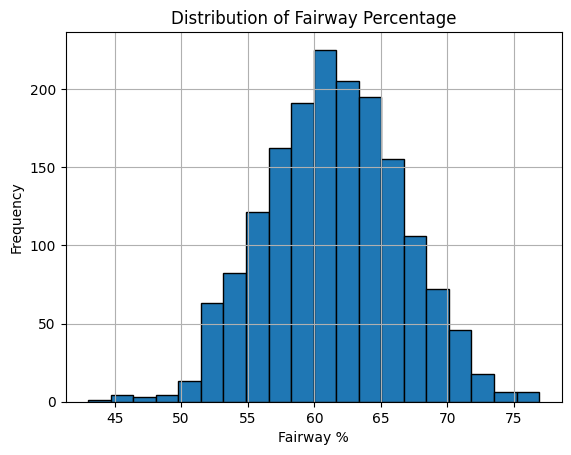

In [101]:
all_tour_data["Fairway Percentage"].hist(bins=20, edgecolor='black')
plt.title("Distribution of Fairway Percentage")
plt.xlabel("Fairway %")
plt.ylabel("Frequency")
plt.show()

In [93]:
all_tour_data["Points"] = pd.to_numeric(all_tour_data["Points"], errors="coerce")

<Figure size 1000x600 with 0 Axes>

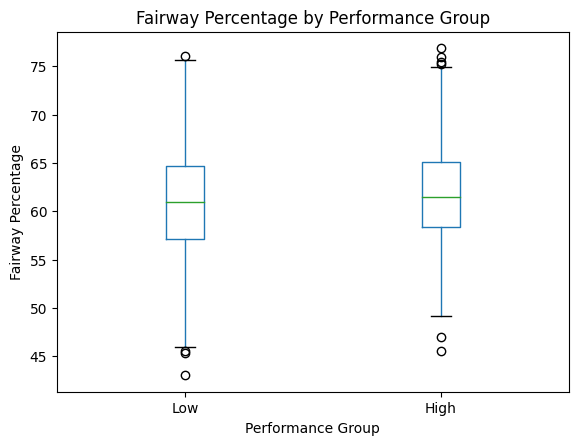

In [103]:
# First, make a simple performance group (top 50% vs bottom 50%)
all_tour_data["Performance Group"] = pd.qcut(all_tour_data["Points"], q=2, labels=["Low", "High"])

# Now boxplot
plt.figure(figsize=(10, 6))

all_tour_data.boxplot(column="Fairway Percentage", by="Performance Group", grid=False)

plt.title("Fairway Percentage by Performance Group")
plt.suptitle("")  # removes automatic extra title
plt.xlabel("Performance Group")
plt.ylabel("Fairway Percentage")

plt.show()

In [97]:
accurate = all_tour_data[all_tour_data["Fairway Percentage"] > 65]["Points"]
less_accurate = all_tour_data[all_tour_data["Fairway Percentage"] <= 65]["Points"]

t_stat, p_val = ttest_ind(accurate.dropna(), less_accurate.dropna())
print("T-statistic:", t_stat)
print("P-value:", p_val)

T-statistic: 2.308743778954412
P-value: 0.021103699601085667


In [99]:
ml_data = all_tour_data[["Fairway Percentage", "Points"]].dropna()
X= ml_data[["Fairway Percentage"]]
y = ml_data["Points"]

model = LinearRegression()
model.fit(X, y)

print("R-squared", model.score(X, y))
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])

R-squared 0.012439234379812092
Intercept: 151.41845754566782
Slope: 5.203718514805958


### Question 2
#### Do players with higher driving distance sacrifice accuracy, and how does this tradeoff impact overall performance?

<function matplotlib.pyplot.show(close=None, block=None)>

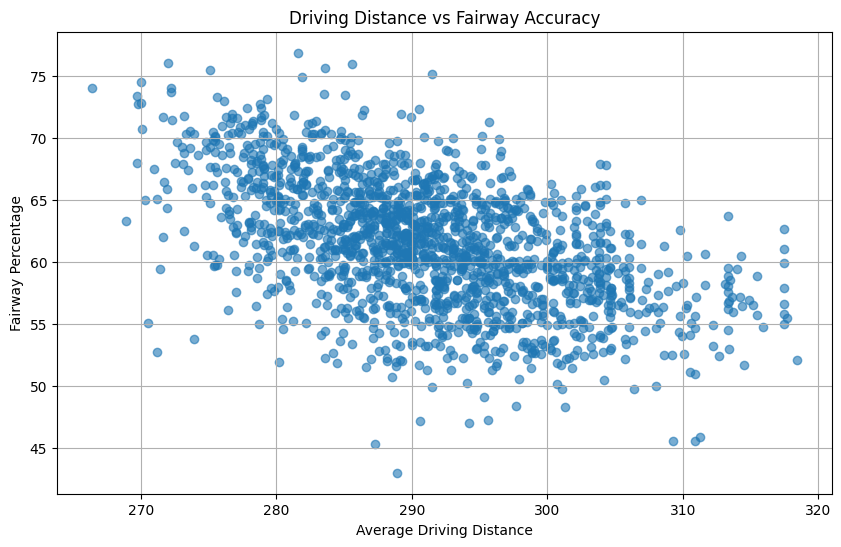

In [87]:
plt.figure(figsize=(10,6))
plt.scatter(all_tour_data["Avg Distance"], all_tour_data["Fairway Percentage"], alpha=0.6)
plt.title("Driving Distance vs Fairway Accuracy")
plt.xlabel("Average Driving Distance")
plt.ylabel("Fairway Percentage")
plt.grid(True)
plt.show

In [89]:
from scipy.stats import ttest_ind

long_hitters = all_tour_data[all_tour_data["Avg Distance"] > 305]["Fairway Percentage"]
short_hitters = all_tour_data[all_tour_data["Avg Distance"] <=305]["Fairway Percentage"]

t_stat2, p_val2 = ttest_ind(long_hitters.dropna(), short_hitters.dropna())
print("T-statistic:", t_stat2)
print("P-value:", p_val2)

T-statistic: -10.425206264228317
P-value: 1.063093566827341e-24
